# Autoencoders

In this notebook, we explore the task of constructing an autoencoder framework tailored for the reconstruction of MNIST images. Our exploration involves the implementation and comparison of both MLP and Convolutional Autoencoder architectures. Through this comparative analysis, we aim to discern the performance characteristics and potential trade-offs between these methodologies.

In [1]:
# First lets load the nescessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# For plotting
import matplotlib.pyplot as plt
import torch.nn.functional as F

The second stage is to load the MNIST dataset. More details about it are available in the CNN notebook.

In [2]:
# MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

### Multi layer perceptron

In our first autoencoder, let's use an MLP and check its performance. We'll also take a look at the latent space representation, so we'll add 'forward' and 'get_encoded_representation' methods to our class.

In [3]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 12)  # Encoded representation
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(12, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Tanh()
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded  # Return both decoded and encoded values

    def get_encoded_representation(self, x):
        # This function can be used to specifically obtain the encoded representation.
        return self.encoder(x)

Now lets define the loss and the optimizer

In [4]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Autoencoder().to(device)

# other hyper parametersnum_epochs
num_epochs = 3
learning_rate = 1e-3

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# lets now begin the training loop
# Training the model
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    with torch.no_grad():
        for data in test_loader:
            img, _ = data
            img = img.view(img.size(0), -1).to(device)
            output = model(img)
            test_loss = criterion(output, img).mean()

            #lets do it for only one batch, as thousand events is enough
            break
        
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')
    #print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/3], Train Loss: 0.1094, Test Loss: 0.1260
Epoch [2/3], Train Loss: 0.1053, Test Loss: 0.1023
Epoch [3/3], Train Loss: 0.0914, Test Loss: 0.0908


Now that the training is finished, lets plot the results

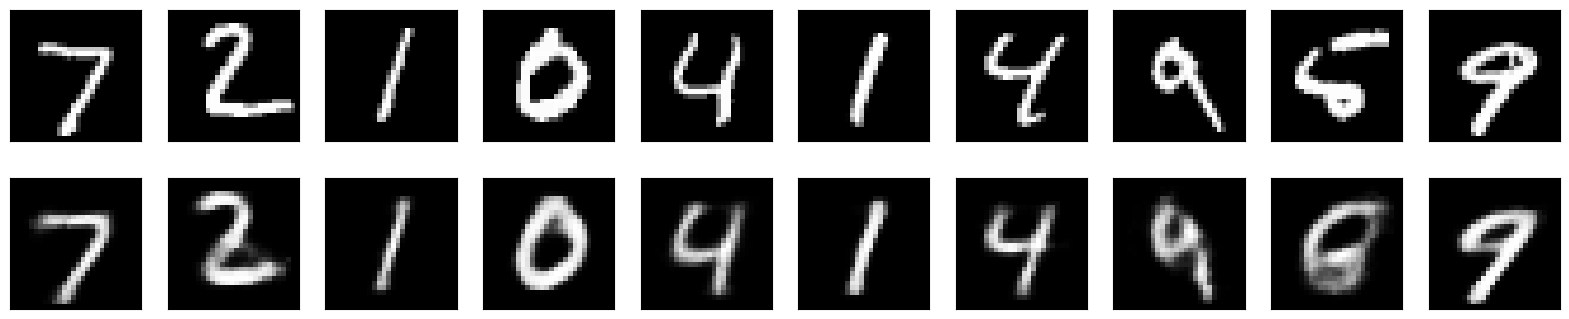

In [5]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get sample outputs
images = images.view(images.size(0), -1).to(device)
output = model(images)
images = images.cpu().view(-1, 1, 28, 28)
output = output.cpu().view(-1, 1, 28, 28)

# Plot the first 10 test images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([images[:10], output[:10]], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)).detach().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()

## Convolution neural networks

Now, let's compare the results with a CNN.

We've observed that convolution operations typically reduce the size of the original image, which suits building the encoder. However, how can we utilize convolution operations to go from the latent space size back to the original image size?

We can use either `Upsampling` or `transposed convolutions`. In this notebook we will explore the `Upsampling` method.

In [18]:
class CNNAutoencoder(nn.Module):
    def __init__(self):
        super(CNNAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),    # Reduce spatial dimensions
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 4, 3, padding=1),    # Further reduce spatial dimensions
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(4, 16, 3, padding=1),    # Increase spatial dimensions
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='nearest'),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.Tanh(),
            nn.Conv2d(16, 1, 3, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [19]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = CNNAutoencoder().to(device)

# other hyper parametersnum_epochs
num_epochs = 3
learning_rate = 1e-3

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        img = img.to(device)
        
        # Forward pass
        output = model(img)
        loss = criterion(output, img)
        
        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        correct = 0
        for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                #print(output[0])
                test_loss = criterion(output, data).mean()


                # lets do it for only one batch, as thousand events is enough
                break
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}')
    #print(f'Epoch {epoch}, Train Loss: {loss:.4f}', f' Test Loss: {test_loss:.4f}')

Epoch [1/3], Train Loss: 0.0272, Test Loss: 0.0283
Epoch [2/3], Train Loss: 0.0262, Test Loss: 0.0238
Epoch [3/3], Train Loss: 0.0248, Test Loss: 0.0221


In [ ]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

# Get sample outputs
images = images.to(device)
output = model(images)
images = images.cpu().view(-1, 1, 28, 28)
output = output.cpu().view(-1, 1, 28, 28)

# Plot the first 10 test images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
for images, row in zip([images[:10], output[:10]], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)).detach().numpy(), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()